Finish training and validate on test data (print confusion matrix and report)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

In [6]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import load

In [7]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [8]:
#dataset is available https://drive.google.com/drive/folders/1WJemKpDspMnvEU_4oyxkxAxgvVihuKr5?usp=sharing
#you can

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision'

In [10]:
import os

In [11]:
directory = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/NA_Fish_Dataset'
clases = os.listdir(directory)

In [12]:
clases

['Trout',
 'Striped Red Mullet',
 'Black Sea Sprat',
 'Red Sea Bream',
 'Red Mullet',
 'Sea Bass',
 'Shrimp',
 'Horse Mackerel',
 'Gilt Head Bream']

In [13]:
clases = clases[:4]

In [14]:
clases

['Trout', 'Striped Red Mullet', 'Black Sea Sprat', 'Red Sea Bream']

In [15]:
directory = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/NA_Fish_Dataset'
train_files = []
target_files = []
for fish_type in clases:
    for file in os.listdir(os.path.join(directory, fish_type)):
        train_files.append(os.path.join(directory, fish_type, file))
        target_files.append(fish_type)

In [16]:
df = pd.DataFrame({'img' : train_files, 'target' : target_files})
df.head()

,img,target
0,/content/drive/MyDrive/Colab Notebooks/Compute...,Trout
1,/content/drive/MyDrive/Colab Notebooks/Compute...,Trout
2,/content/drive/MyDrive/Colab Notebooks/Compute...,Trout
3,/content/drive/MyDrive/Colab Notebooks/Compute...,Trout
4,/content/drive/MyDrive/Colab Notebooks/Compute...,Trout


In [17]:
len(df)

180

In [18]:
img = []
for ind in tqdm.tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df['img'] = img

100%|██████████| 180/180 [00:07<00:00, 24.83it/s]


In [19]:
torch.cuda.is_available()

True

In [20]:
df.head()

,img,target
0,"[[[159, 127, 79], [160, 129, 80], [164, 133, 9...",Trout
1,"[[[185, 155, 106], [199, 168, 121], [201, 169,...",Trout
2,"[[[31, 15, 8], [29, 15, 7], [27, 17, 5], [26, ...",Trout
3,"[[[142, 119, 74], [142, 119, 80], [142, 121, 7...",Trout
4,"[[[119, 89, 42], [121, 87, 43], [124, 91, 47],...",Trout


In [21]:
df['target'].unique()

array(['Trout', 'Striped Red Mullet', 'Black Sea Sprat', 'Red Sea Bream'],
      dtype=object)

In [22]:
y = []
for i in range(len(df['target'])):
    for j in range(len(clases)):
        if df['target'][i] == clases[j]:
            y.append(j)

In [23]:
df.head()

,img,target
0,"[[[159, 127, 79], [160, 129, 80], [164, 133, 9...",Trout
1,"[[[185, 155, 106], [199, 168, 121], [201, 169,...",Trout
2,"[[[31, 15, 8], [29, 15, 7], [27, 17, 5], [26, ...",Trout
3,"[[[142, 119, 74], [142, 119, 80], [142, 121, 7...",Trout
4,"[[[119, 89, 42], [121, 87, 43], [124, 91, 47],...",Trout


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

In [25]:
len(y_train)

144

In [26]:
len(y_test)

36

In [27]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [28]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels= 6,  # in_channels = out_channels of self.conv1
                               out_channels=16,
                               kernel_size=5)
        self.fc1 = nn.Linear(16*61*61, 120)  # Size of the last layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4) # Number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)

        x_size = x.view(x.size(0), -1).size(1)

        x = x.view(-1, x_size)
        # x = x.view(-1, 16*61*61)  # output size to one dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [29]:
if torch.cuda.is_available():
  net = MyConvNet().cuda()
else:
  net = MyConvNet()

batch = []



batch = next(iter(trainloader))
print(batch[0].shape)

#net.forward(torch.FloatTensor(batch[0]))

torch.Size([4, 3, 256, 256])


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
running_loss = 0
# iterations
for epoch in (range(10)):
    train_loss = []
    test_loss = []
    for i, batch in enumerate(trainloader):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device=device, dtype=torch.float32)
        y_batch = y_batch.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        net.train(False)

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X_test_batch, y_pred_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_pred_batch = y_pred_batch.to(device = device, dtype = torch.long)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_pred_batch)
            test_loss.append(test_l.item())
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))


epoch  0  train_loss  1.378072053194046  test_loss  1.3810119893815782
epoch  1  train_loss  1.3380410903029971  test_loss  1.3524483309851751
epoch  2  train_loss  1.2407683928807576  test_loss  1.218184060520596
epoch  3  train_loss  1.0676455464628007  test_loss  1.0839706791771784
epoch  4  train_loss  0.8502185717225075  test_loss  1.0193348129590352
epoch  5  train_loss  0.6555989471574625  test_loss  0.9535796410507626
epoch  6  train_loss  0.5127036881943544  test_loss  0.8963993986447653
epoch  7  train_loss  0.4084182348516252  test_loss  0.8429657634761598
epoch  8  train_loss  0.3229842450883653  test_loss  0.7752245863278707
epoch  9  train_loss  0.25724078093965846  test_loss  0.6987808760669496


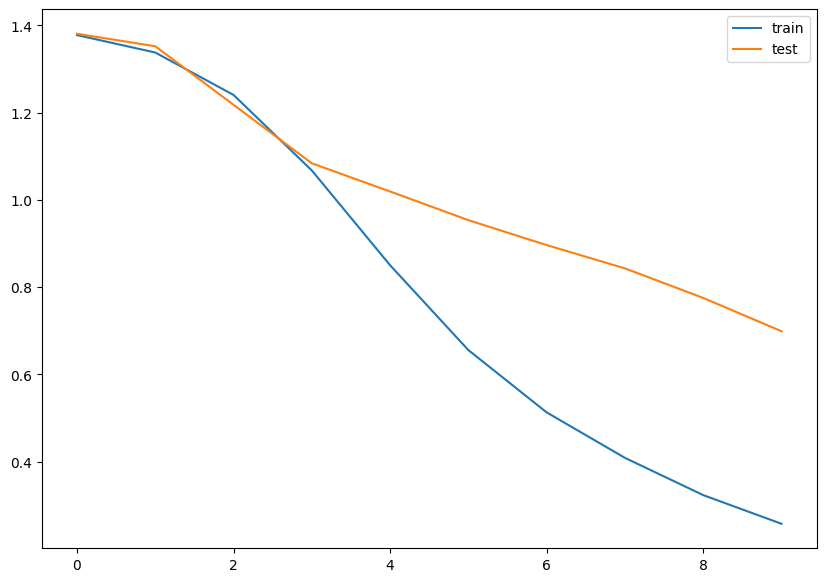

In [32]:
plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [33]:
# Test your model on X_test data and show confusion_matrix and classification_report

from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np

net.eval()  # Set the model to evaluation mode
y_true = []  # Ground truth labels
y_pred = []  # Predicted logits

with torch.no_grad():
    for i, batch in enumerate(testloader):
        X_test_batch, y_test_batch = batch
        X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
        y_test_pred = net(X_test_batch)

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(y_test_pred.cpu().detach())

# Convert lists to NumPy arrays
test = np.array(y_true)

# Get the predicted class labels
pred = np.argmax(np.array([tensor.numpy() for tensor in y_pred]), axis=1)

In [34]:
y_pred[:5]

[tensor([-1.8416, -0.5599, -2.7380,  2.6671]),
 tensor([-4.1848,  1.3561,  2.1196,  0.1081]),
 tensor([ 0.2191,  0.4028, -0.4125, -2.2233]),
 tensor([-0.6704, -0.9553, -3.6066,  2.0706]),
 tensor([-2.4557,  0.6915,  2.8198, -2.0843])]

In [35]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[ 4  1  0  0]
 [ 0  6  8  0]
 [ 0  0 11  0]
 [ 0  1  0  5]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.75      0.43      0.55        14
           2       0.58      1.00      0.73        11
           3       1.00      0.83      0.91         6

    accuracy                           0.72        36
   macro avg       0.83      0.77      0.77        36
weighted avg       0.77      0.72      0.71        36



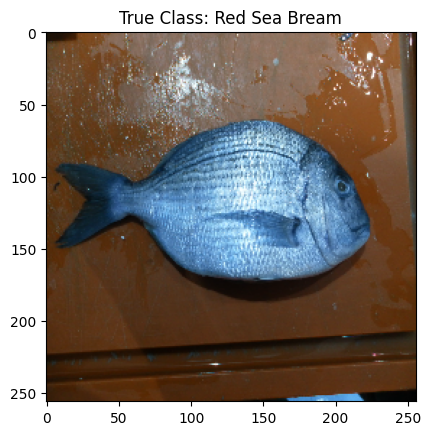

Predicted Class: Red Sea Bream 



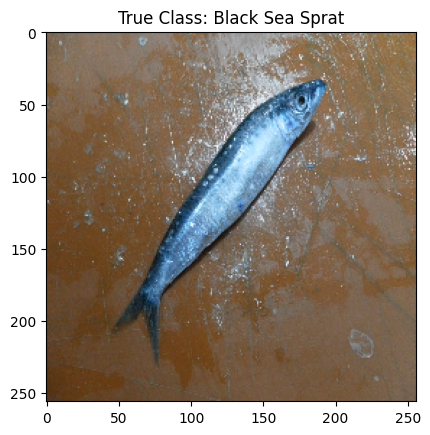

Predicted Class: Black Sea Sprat 



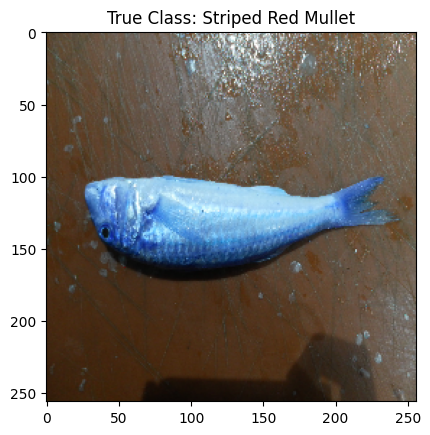

Predicted Class: Striped Red Mullet 



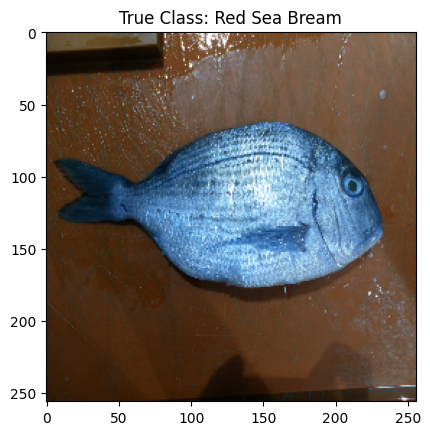

Predicted Class: Red Sea Bream 



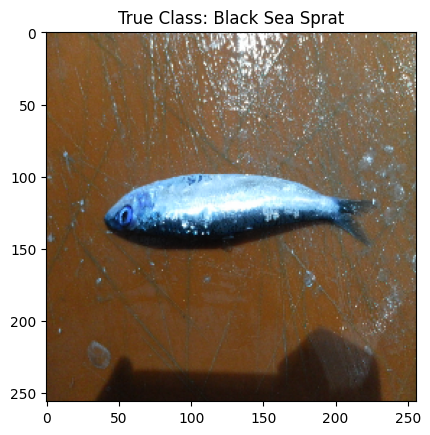

Predicted Class: Black Sea Sprat 



In [36]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def predict_single_image(image_path, model, transform):
    # Image preprocessing

    img = Image.fromarray(image_path)
    img = img.resize((256, 256))
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Making prediction
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        prediction = model(img_tensor)

    # Convert prediction to class label
    predicted_class = torch.argmax(prediction).item()

    return predicted_class

# Predictoins itself
for i in range(5):
  image_index = i  # Desired image
  image_path = X_test[image_index]

  # Display image
  plt.imshow(Image.fromarray(image_path))  # Convert numpy array to PIL Image
  plt.title(f"True Class: {clases[y_test[image_index]]}")
  plt.show()

  # Make a prediction
  predicted_class = predict_single_image(image_path, net, transform)
  print(f"Predicted Class: {clases[predicted_class]} \n")
